### Fine Tuning Falcon-7B Model
In this project I've attempted to finetune Falcon 7B model on Patient Conversation with a mental health provider.

##### Install dependencies
In order to get started we need to install the appropriate dependencies



In [22]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.2 MB/s eta 0:00:0000:010:01


In [1]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git -q
!pip install -q datasets bitsandbytes einops wandb -q
!pip install huggingface_hub -q
!pip install WordCloud

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.12.1 requires fsspec==2023.12.1, but you have fsspec 2023.10.0 which is incompatible.


In [13]:
import matplotlib.pyplot as plt

## Download the base model

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [15]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [16]:
model_name = "tiiuae/falcon-7b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
from peft import prepare_model_for_kbit_training

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )



In [14]:
from peft import LoraConfig, get_peft_model

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=['query_key_value',
                    'dense',
                    "dense_h_to_4h",
                    "dense_4h_to_h"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


trainable params: 16318464 || all params: 3625063296 || trainable%: 0.4501566639679441


## Download the finetuning dataset
In this case we're using Mental Health Counseling conversations dataset

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [18]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from datasets import Dataset
data = load_dataset("Amod/mental_health_counseling_conversations")

In [19]:
all_data = data['train']

In [20]:
all_context, all_response = zip(*[(example['Context'], example['Response']) for example in data["train"]])

### Exploratory Data Analysis

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# stop_words = set(stopwords.words('english'))
 
# word_tokens = word_tokenize(example_sent)

In [22]:
context_str_length  = [len(d) for d in all_context]
response_str_length  = [len(d) for d in all_response]

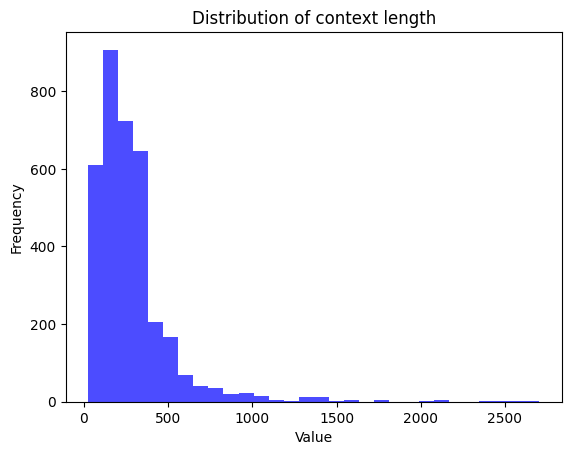

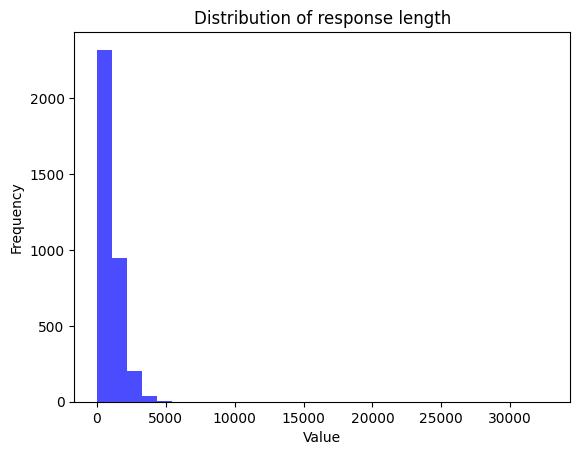

In [24]:
plt.hist(context_str_length, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of context length')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.hist(response_str_length, bins=30, color='blue',  alpha=0.7)
plt.title('Distribution of response length')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Before cleaning 


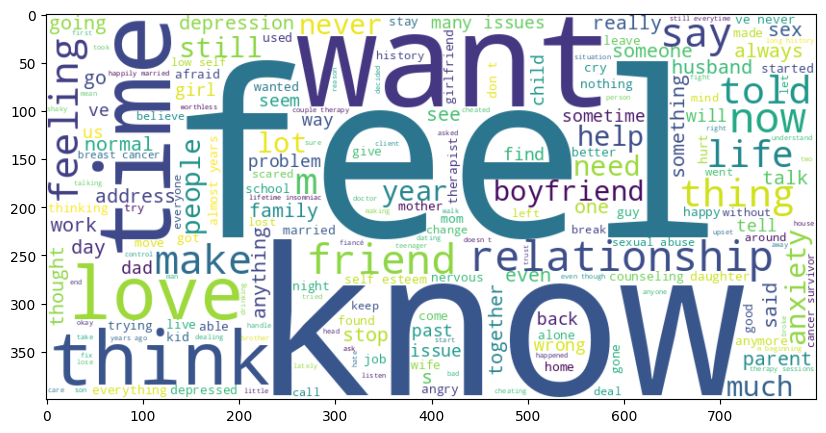

In [135]:
d = all_context
all_text = ' '.join(d)

print("Before cleaning ")
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# all_text = all_text.split(' ')
# print("Length before cleaning : ", len(all_text))
# all_text =   [w for w in all_text if not w.lower() in stop_words]
# print("Length after cleaning : ", len(all_text))
# all_text = ' '.join(all_text)

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.show()

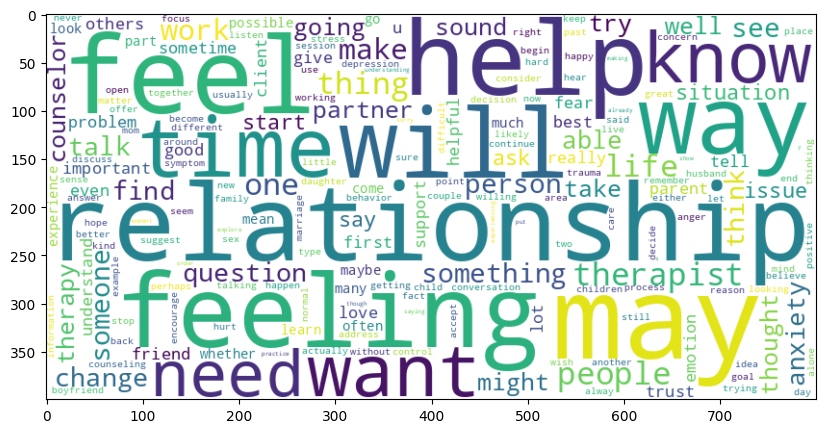

In [27]:
d = all_response
all_text = ' '.join(d)

# all_text= all_text.split(' ')
# print("Length before cleaning : ", len(all_text))
# all_text =   [w for w in all_text if not w.lower() in stop_words]
# print("Length after cleaning : ", len(all_text))
# all_text = ' '.join(all_text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

### Convert the dataset into the following format : < Human > : data , < Assistant > : data

In [29]:
text = ''
all_data = []
for idx, example in enumerate(data["train"]):
#       New Line removal and backslashes removal 
#       context=example['Context'].replace('\n', ' ').replace('\\', '')
#       response=example['Response'].replace('\n', ' ').replace('\\', '')
      context=example['Context']
      response=example['Response']
      human = '<HUMAN>:' + str(context)
      assistant = '<ASSISTANT>:' + str(response)
      conversation = human + '\n' +  assistant
      if idx==1:
        print(conversation)
      all_data.append(conversation)


<HUMAN>:I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?
<ASSISTANT>:Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People ofte

### Split the data into 80/20 

In [30]:
X_train, X_test = train_test_split(all_data, test_size =0.2)
data_train = Dataset.from_dict({
    "text": [conversation for conversation in X_train]
})
data_test = Dataset.from_dict({
    "text": [conversation for conversation in X_test]
})
print("Train : ", len(X_train))
print("Test : ", len(X_test))

Train :  2809
Test :  703


In [49]:
avg_word_length_train = np.mean([len(word) for word in X_train])
print("Average word length in X_train:", avg_word_length_train)

avg_word_length_test = np.mean([len(word) for word in X_test])
print("Average word length in X_test:", avg_word_length_test)

Average word length in X_train: 1331.3549305802776
Average word length in X_test: 1323.1934566145092


In [40]:
import numpy as np
mean_length = np.mean(context_str_length)
print("Average length:", mean_length)

Average length: 282.65233485193625


In [41]:
import numpy as np
mean_length = np.mean(response_str_length)
print("Average length:", mean_length)

Average length: 1026.0689066059226


### Save the data as backup to use in future

In [31]:
import pandas as pd
df_train = pd.DataFrame({"text": X_train})
df_test = pd.DataFrame({"text": X_test})


data_train = Dataset.from_pandas(df_train)
data_test = Dataset.from_pandas(df_test)


df_train.to_csv("train_dataset.csv", index=False)
df_test.to_csv("test_dataset.csv", index=False)

## Model Training


#### Reference for code : https://github.com/iamarunbrahma/finetuned-qlora-falcon7b-medical



In [59]:
output_dir = "./falcon_7b_instruct_trained_mental_health_lora"
per_device_train_batch_size = 16 # reduce batch size by 2x if out-of-memory error
gradient_accumulation_steps = 16  # increase gradient accumulation steps by 2x if batch size is reduced
optim = "paged_adamw_32bit" # activates the paging for better memory management
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 100 # number of updates steps before two checkpoint saves
logging_steps = 10  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 0.5 * 2e-3  # learning rate for AdamW optimizer
max_grad_norm = 0.3 # maximum gradient norm (for gradient clipping)
max_steps = 600
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate
lr_scheduler_type = "cosine"  # learning rate scheduler

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)
%timeit

#### SFTT Trainer : https://huggingface.co/docs/trl/sft_trainer

In [60]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data_train,
    eval_dataset=data_test,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)

Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

#### Code for upcasting parameters

### Upcasting the parameters
https://colab.research.google.com/drive/1BiQiw31DT7-cDp1-0ySXvvhzqomTdI-o?usp=sharing

In [56]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [ ]:
model.config.use_cache = False
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/vk2501/.netrc


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,2.547000
20,2.246600


In [62]:
print("finished")

finished


In [63]:
model.push_to_hub(repo_id='vkamal/falcon_fine_tuned_7b_instruct')
trainer.push_to_hub()

adapter_model.safetensors:   0%|          | 0.00/65.3M [00:00<?, ?B/s]

events.out.tfevents.1703099903.instance-1:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/65.3M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vkamal/falcon_7b_instruct_trained_mental_health_lora/commit/af9c36c7479771235039c780432156bb29aac841', commit_message='End of training', commit_description='', oid='af9c36c7479771235039c780432156bb29aac841', pr_url=None, pr_revision=None, pr_num=None)

In [64]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/vkamal/falcon_7b_instruct_trained_mental_health_lora/commit/4d7bc78cfbfa1edb33041b50dd32dd680d22f8fb', commit_message='End of training', commit_description='', oid='4d7bc78cfbfa1edb33041b50dd32dd680d22f8fb', pr_url=None, pr_revision=None, pr_num=None)

### Test the model by relaoding the trained model from hugging face

In [65]:
model_name = "vkamal/falcon_7b_instruct_trained_mental_health_lora"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)


adapter_config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/65.3M [00:00<?, ?B/s]

In [66]:
from peft import LoraConfig, get_peft_model

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=['query_key_value',
                    'dense',
                    "dense_h_to_4h",
                    "dense_4h_to_h"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


trainable params: 16318464 || all params: 3625063296 || trainable%: 0.4501566639679441


In [67]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/427 [00:00<?, ?B/s]

In [68]:
trainer = SFTTrainer(
    model=model,
    eval_dataset =data_test,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
)

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

In [69]:
metrics = trainer.evaluate()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [70]:
print(metrics)

{'eval_loss': 2.6474225521087646, 'eval_runtime': 49.3557, 'eval_samples_per_second': 14.244, 'eval_steps_per_second': 1.783}


### Compare the results from the original model

In [25]:
### Original Model Loading
model_name = "tiiuae/falcon-7b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# Loading PEFT model
# PEFT_MODEL = "vkamal/falcon_fine_tuned"

PEFT_MODEL = "vkamal/falcon_7b_instruct_trained_mental_health_lora"
config = PeftConfig.from_pretrained(PEFT_MODEL)
peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

peft_model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)

peft_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
def generate_answer(query, system_prompt=system_prompt,  max_new_tokens=256,  temperature=0.4):
  print(query)

  user_prompt = f"""<Human>: {query}
  : """

  final_prompt = system_prompt + "\n" + user_prompt

  device = "cuda:0"
  dashline = "-".join("" for i in range(50))

  encoding = tokenizer(final_prompt, return_tensors="pt").to(device)
  outputs = original_model.generate(input_ids=encoding.input_ids, generation_config=GenerationConfig(max_new_tokens=256, pad_token_id = tokenizer.eos_token_id, \
                                                                                                                     eos_token_id = tokenizer.eos_token_id, attention_mask = encoding.attention_mask, \
                                                                                                                     temperature=0.4, top_p=0.6, repetition_penalty=1.3, num_return_sequences=1,))
  text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

  print(dashline)
  print(f'ORIGINAL MODEL RESPONSE:\n{text_output}')
  print(dashline)

  peft_encoding = peft_tokenizer(final_prompt, return_tensors="pt").to(device)
  peft_outputs = peft_model.generate(input_ids=peft_encoding.input_ids, generation_config=GenerationConfig(max_new_tokens=256, pad_token_id = peft_tokenizer.eos_token_id, \
                                                                                                                     eos_token_id = peft_tokenizer.eos_token_id, attention_mask = peft_encoding.attention_mask, \
                                                                                                                     temperature=0.4, top_p=0.6, repetition_penalty=1.3, num_return_sequences=1,))
  peft_text_output = peft_tokenizer.decode(peft_outputs[0], skip_special_tokens=True)

  print(f'PEFT MODEL RESPONSE:\n{peft_text_output}')
  print(dashline)

### Query 1 

In [8]:
data_train['text'][0]

In [29]:
query = "My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines"
print(len(query))

161


In [30]:
system_prompt = """Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'."""

generate_answer(query, system_prompt=system_prompt)

My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuratio

-------------------------------------------------
ORIGINAL MODEL RESPONSE:
Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines
  : 
I'm sorry, I don't know the answer to this question.
I'm sorry, I don't know the answer to this question.
-------------------------------------------------
PEFT MODEL RESPONSE:
Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she w

In [31]:
system_prompt = """Assume you’re a psychologist and you’ve all the knowledge needed. Based on this, answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'."""

generate_answer(query, system_prompt=system_prompt)

My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
Assume you’re a psychologist and you’ve all the knowledge needed. Based on this, answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines
  : 
It is not uncommon for children in later elementary school to have difficulty with coloring in the lines and writing legibly. It is important to consult a psychiatrist if you are concerned about your daughter's development.
-------------------------------------------------
PEFT 

In [32]:
system_prompt = """ """

generate_answer(query, system_prompt=system_prompt)

My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
 
<Human>: My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she writes unless there are big spaces or she skips lines
  : (

It's possible that the child is simply not yet developmentally ready for coloring in the lines. It's also possible that the child is struggling with fine motor skills, which could be affecting their ability to write and draw. It's important to continue to provide opportunities for learning and practice, and to be patient and understanding with your daughter as she develops her skills.
-------------------------------------------------
PEFT MODEL RESPONSE:
 
<Human>: My daughter is in later elementary school. She can't color in the lines. Her words jumble together when she write

### Query 2 

In [33]:
query = "What are the signs of depression and mental health?"


In [34]:
system_prompt = """Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'."""

generate_answer(query, system_prompt=system_prompt)

What are the signs of depression and mental health?
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: What are the signs of depression and mental health?
  : 
Depression can manifest in various ways, including persistent sadness, loss of interest in activities, changes in appetite, sleep patterns, fatigue, feelings of worthlessness, and difficulty concentrating. Mental health is an overall term that encompasses both physical and mental wellbeing. It is important to seek professional help if you or someone you know is experiencing any of these symptoms.
-------------------------------------------------
PEFT MODEL RESPONSE:
Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answ

In [35]:
system_prompt = """Assume you’re a psychologist and you’ve all the knowledge needed. Based on this, answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'."""

generate_answer(query, system_prompt=system_prompt)

What are the signs of depression and mental health?
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
Assume you’re a psychologist and you’ve all the knowledge needed. Based on this, answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: What are the signs of depression and mental health?
  : 1. Persistent sadness or emptiness
  : 2. Loss of interest in activities once enjoyed
  : 3. Changes in appetite or weight
  : 4. Difficulty sleeping or oversleeping
  : 5. Feelings of worthlessness or guilt
  : 6. Inability to concentrate or make decisions
  : 7. Thoughts of self-harm or suicide
  : 8. Social withdrawal or decreased interactions with friends and family
  : 9. Extended periods of sadness or irritability
  : 10. Lack of energy or motivation
---------------------------------------

In [36]:
system_prompt = """ """

generate_answer(query, system_prompt=system_prompt)

What are the signs of depression and mental health?
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
 
<Human>: What are the signs of depression and mental health?
  : <Human>: What are some common symptoms of depression?
  : <Human>: What are some common symptoms of anxiety?
  : <Human>: What are some common symptoms of bipolar disorder?
  : <Human>: What are some common symptoms of post-traumatic stress disorder?
  : <Human>: What are some common symptoms of obsessive-compulsive disorder?
  : <Human>: What are some common symptoms of eating disorders?
  : <Human>: What are some common symptoms of substance abuse disorders?
  : <Human>: What are some common symptoms of personality disorders?
  : <Human>: What are some common symptoms of psychotic disorders?
  : <Human>: What are some common symptoms of schizophrenia?
  : <Human>: What are some common symptoms of bipolar disorder?
  : <Human>: What are some common symptoms of depression?
  : <Human>: What are 

### Query 3 

In [38]:
query = "After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/"
print(len(query))


117


In [39]:
system_prompt = """Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'."""

generate_answer(query, system_prompt=system_prompt)

After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/
  : 
I'm sorry, I don't know the answer to this question.
-------------------------------------------------
PEFT MODEL RESPONSE:
Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: After he got home from the hospital he was angry, then for a time wonderful.  Now he is 

In [40]:
system_prompt = """Assume you’re a psychologist and you’ve all the knowledge needed. Based on this, answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'."""

generate_answer(query, system_prompt=system_prompt)

After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
Assume you’re a psychologist and you’ve all the knowledge needed. Based on this, answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult a psychiatrist for further queries.'.
<Human>: After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/
  : 
I am sorry, as a language model, I cannot provide personal advice or diagnose medical conditions. It is important to seek professional help from a licensed healthcare provider if you are experiencing any mental health concerns.
-------------------------------------------------
PEFT MODEL RESPONSE:
Assume you’re a psychologist and you’ve all the knowledge needed. Ba

In [41]:
system_prompt = """ """

generate_answer(query, system_prompt=system_prompt)

After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/
-------------------------------------------------
ORIGINAL MODEL RESPONSE:
 
<Human>: After he got home from the hospital he was angry, then for a time wonderful.  Now he is depressed and hopeless again/
  : <Human>: He is still in the hospital, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is getting better.  He is still in a lot of pain, but he is